# Fisher's method vs. min (after multiple comparison's correction)

In [1]:
from pkg.utils import set_warnings

set_warnings()

import datetime
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from myst_nb import glue as default_glue
from pkg.data import load_network_palette, load_node_palette, load_unmatched
from pkg.io import savefig
from pkg.plot import set_theme
from pkg.stats import stochastic_block_test
from graspologic.simulations import sbm
from tqdm import tqdm
import matplotlib.colors as colors
from scipy.stats import binom, combine_pvalues
from pkg.stats import binom_2samp
import matplotlib.colors as colors
from pathlib import Path


DISPLAY_FIGS = True

FILENAME = "compare_sbm_methods_sim"


def gluefig(name, fig, **kwargs):
    savefig(name, foldername=FILENAME, **kwargs)

    glue(name, fig, prefix="fig")

    if not DISPLAY_FIGS:
        plt.close()


def glue(name, var, prefix=None):
    savename = f"{FILENAME}-{name}"
    if prefix is not None:
        savename = prefix + ":" + savename
    default_glue(savename, var, display=False)


t0 = time.time()
set_theme()
rng = np.random.default_rng(8888)

network_palette, NETWORK_KEY = load_network_palette()
node_palette, NODE_KEY = load_node_palette()
fisher_color = sns.color_palette("Set2")[2]
min_color = sns.color_palette("Set2")[3]

GROUP_KEY = "simple_group"

left_adj, left_nodes = load_unmatched(side="left")
right_adj, right_nodes = load_unmatched(side="right")

left_labels = left_nodes[GROUP_KEY].values
right_labels = right_nodes[GROUP_KEY].values

In [2]:
stat, pvalue, misc = stochastic_block_test(
    left_adj,
    right_adj,
    labels1=left_labels,
    labels2=right_labels,
    method="fisher",
    combine_method="fisher",
)

## Model for simulations
We have fit a stochastic block model to the left and right hemispheres. Say the
probabilities of group-to-group connections *on the left* are stored in the matrix
$B$, so that $B_{kl}$ is the probability of an edge from group $k$ to $l$.

Let $\tilde{B}$ be a *perturbed* matrix of probabilities. We are interested in testing
$H_0: B = \tilde{B}$ vs. $H_a: ... \neq ...$. To do so, we compare each
$H_0: B_{kl} = \tilde{B}_{kl}$ using Fisher's exact test. This results in p-values for
each $(k,l)$ comparison, $\{p_{1,1}, p_{1,2}...p_{K,K}\}$.

Now, we still are after an overall test for the equality $B = \tilde{B}$. Thus, we
need a way to combine p-values $\{p_{1,1}, p_{1,2}...p_{K,K}\}$ to get an *overall*
p-value for our test comparing the stochastic block model probabilities. One way is
Fisher's method; another is to take the
minimum p-value out of a collection of p-values which have been corrected for multiple
comparisons (say, via Bonferroni or Holm-Bonferroni).

To compare how these two alternative methods of combining p-values work, we did the
following simulation:

- Let $t$ be the number of probabilities to perturb.
- Let $\delta$ represent the strength of the perturbation (see model below).
- For each trial:
   - Randomly select $t$ probabilities without replacement from the elements of $B$
   - For each of these elements, $\tilde{B}_{kl} = TN(B_{kl}, \delta B_{kl})$ where
     $TN$ is a truncated normal distribution, such that probabilities don't end up
     outside of [0, 1].
   - For each element *not* perturbed, $\tilde{B}_{kl} = B_{kl}$
   - Sample the number of edges from each block under each model. In other words, let
     $m_{kl}$ be the number of edges in the $(k,l)$-th block, and let $n_k, n_l$ be
     the number of edges in the $k$-th and $l$-th blocks, respectively. Then, we have

     $$m_{kl} \sim Binomial(n_k n_l, B_{kl})$$

     and likewise for $\tilde{m}_{kl}$.
   - Run Fisher's exact test to generate a $p_{kl}$ for each $(k,l)$.
   - Run Fisher's method for combining p-values, and take the minimum p-value after
     Bonferroni correction.
- These trials were repeated for $\delta \in \{0.1, 0.2, 0.3, 0.4, 0.5\}$ and
$t \in \{25, 50, 75, 100, 125\}$. For each $(\delta, t)$ we ran 100 replicates of the
model/test above.

In [3]:

B_base = misc["probabilities1"].values
inds = np.nonzero(B_base)
base_probs = B_base[inds]
n_possible_matrix = misc["possible1"].values
ns = n_possible_matrix[inds]

n_sims = 100
n_perturb_range = np.linspace(0, 125, 6, dtype=int)[1:]
perturb_size_range = np.round(np.linspace(0, 0.5, 6), decimals=3)[1:]
print(f"Perturb sizes: {perturb_size_range}")
print(f"Perturb number range: {n_perturb_range}")
n_runs = n_sims * len(n_perturb_range) * len(perturb_size_range)
print(f"Number of runs: {n_runs}")

Perturb sizes: [0.1 0.2 0.3 0.4 0.5]
Perturb number range: [ 25  50  75 100 125]
Number of runs: 2500


In [4]:

RERUN_SIM = False
save_path = Path(
    "/Users/bpedigo/JHU_code/bilateral/bilateral-connectome/results/"
    "outputs/compare_sbm_methods_sim/results.csv"
)

if RERUN_SIM:
    t0 = time.time()
    mean_itertimes = 0
    n_time_first = 5
    progress_steps = 0.05
    progress_counter = 0
    last_progress = -0.05
    simple_rows = []
    example_perturb_probs = {}
    for perturb_size in perturb_size_range:
        for n_perturb in n_perturb_range:
            for sim in range(n_sims):
                itertime = time.time()

                # just a way to track progress
                progress_counter += 1
                progress_prop = progress_counter / n_runs
                if progress_prop - progress_steps > last_progress:
                    print(f"{progress_prop:.2f}")
                    last_progress = progress_prop

                # choose some elements to perturb
                currtime = time.time()
                perturb_probs = base_probs.copy()
                choice_indices = rng.choice(
                    len(perturb_probs), size=n_perturb, replace=False
                )

                # pertub em
                for index in choice_indices:
                    prob = base_probs[index]

                    new_prob = -1
                    while new_prob <= 0 or new_prob >= 1:
                        new_prob = rng.normal(prob, scale=prob * perturb_size)

                    perturb_probs[index] = new_prob

                if sim == 0:
                    example_perturb_probs[(perturb_size, n_perturb)] = perturb_probs

                perturb_elapsed = time.time() - currtime

                # sample some new binomial data
                currtime = time.time()

                base_samples = binom.rvs(ns, base_probs)
                perturb_samples = binom.rvs(ns, perturb_probs)
                sample_elapsed = time.time() - currtime

                currtime = time.time()

                # test on the new data
                def tester(cell):
                    stat, pvalue = binom_2samp(
                        base_samples[cell],
                        ns[cell],
                        perturb_samples[cell],
                        ns[cell],
                        null_odds=1,
                        method="fisher",
                    )
                    return pvalue

                pvalue_collection = np.vectorize(tester)(np.arange(len(base_samples)))
                pvalue_collection = np.array(pvalue_collection)
                n_overall = len(pvalue_collection)
                pvalue_collection = pvalue_collection[~np.isnan(pvalue_collection)]
                n_tests = len(pvalue_collection)
                n_skipped = n_overall - n_tests
                test_elapsed = time.time() - currtime

                # combine pvalues
                currtime = time.time()
                row = {
                    "perturb_size": perturb_size,
                    "n_perturb": n_perturb,
                    "sim": sim,
                    "n_tests": n_tests,
                    "n_skipped": n_skipped,
                }
                for method in ["fisher", "min"]:
                    row = row.copy()
                    if method == "min":
                        overall_pvalue = min(pvalue_collection.min() * n_tests, 1)
                        row["pvalue"] = overall_pvalue
                    elif method == "fisher":
                        stat, overall_pvalue = combine_pvalues(
                            pvalue_collection, method="fisher"
                        )
                        row["pvalue"] = overall_pvalue

                    row["method"] = method
                    simple_rows.append(row)

                combine_elapsed = time.time() - currtime

                if progress_counter < n_time_first:
                    print("-----")
                    print(f"Perturb took {perturb_elapsed:0.3f}s")
                    print(f"Sample took {sample_elapsed:0.3f}s")
                    print(f"Test took {test_elapsed:0.3f}s")
                    print(f"Combine took {combine_elapsed:0.3f}s")
                    print("-----")
                    iter_elapsed = time.time() - itertime
                    mean_itertimes += iter_elapsed / n_time_first
                elif progress_counter == n_time_first:
                    projected_time = mean_itertimes * n_runs
                    projected_time = datetime.timedelta(seconds=projected_time)
                    print("---")
                    print(f"Projected time: {projected_time}")
                    print("---")

    total_elapsed = time.time() - t0

    print("Done!")
    print(f"Total experiment took: {datetime.timedelta(seconds=total_elapsed)}")
    results = pd.DataFrame(simple_rows)

    results.to_csv(save_path)
else:
    results = pd.read_csv(save_path, index_col=0)

In [5]:
if RERUN_SIM:
    fig, axs = plt.subplots(
        len(perturb_size_range), len(n_perturb_range), figsize=(20, 20), sharey=True
    )

    for i, perturb_size in enumerate(perturb_size_range):
        for j, n_perturb in enumerate(n_perturb_range):
            ax = axs[i, j]
            perturb_probs = example_perturb_probs[(perturb_size, n_perturb)]
            mask = base_probs != perturb_probs
            show_base_probs = base_probs[mask]
            show_perturb_probs = perturb_probs[mask]
            sort_inds = np.argsort(-show_base_probs)
            show_base_probs = show_base_probs[sort_inds]
            show_perturb_probs = show_perturb_probs[sort_inds]

            sns.scatterplot(
                x=np.arange(len(show_base_probs)), y=show_perturb_probs, ax=ax, s=10
            )
            sns.lineplot(
                x=np.arange(len(show_base_probs)),
                y=show_base_probs,
                ax=ax,
                linewidth=1,
                zorder=-1,
                color="orange",
            )
            ax.set(xticks=[])

    ax.set(yscale="log")

    gluefig("example-perturbations", fig)

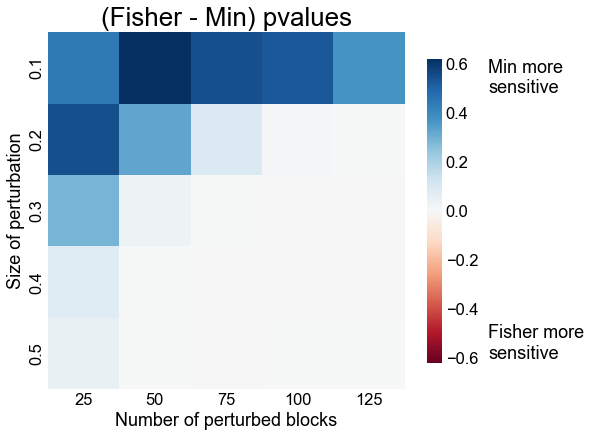

In [6]:


fisher_results = results[results["method"] == "fisher"]
min_results = results[results["method"] == "min"]

fisher_means = fisher_results.groupby(["perturb_size", "n_perturb"]).mean()
min_means = min_results.groupby(["perturb_size", "n_perturb"]).mean()

mean_diffs = fisher_means["pvalue"] - min_means["pvalue"]
mean_diffs = mean_diffs.to_frame().reset_index()

mean_diffs_square = mean_diffs.pivot(
    index="perturb_size", columns="n_perturb", values="pvalue"
)

v = np.max(np.abs(mean_diffs_square.values))

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sns.heatmap(
    mean_diffs_square,
    cmap="RdBu",
    ax=ax,
    yticklabels=perturb_size_range,
    xticklabels=n_perturb_range,
    square=True,
    center=0,
    vmin=-v,
    vmax=v,
    cbar_kws=dict(shrink=0.7),
)
ax.set(xlabel="Number of perturbed blocks", ylabel="Size of perturbation")
cax = fig.axes[1]
cax.text(4, 1, "Min more\nsensitive", transform=cax.transAxes, va="top")
cax.text(4, 0, "Fisher more\nsensitive", transform=cax.transAxes, va="bottom")
ax.set_title("(Fisher - Min) pvalues", fontsize="x-large")
DISPLAY_FIGS = True
gluefig("pvalue_diff_matrix", fig)

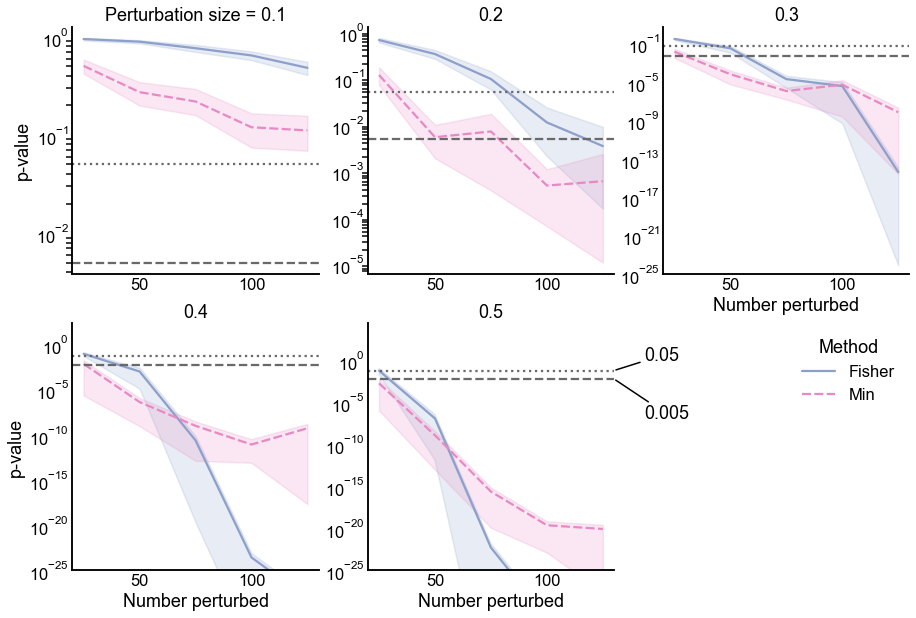

In [7]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

method_palette = {"fisher": fisher_color, "min": min_color}

for i, perturb_size in enumerate(perturb_size_range):
    ax = axs.flat[i]
    plot_results = results[results["perturb_size"] == perturb_size]
    sns.lineplot(
        data=plot_results,
        x="n_perturb",
        y="pvalue",
        hue="method",
        style="method",
        palette=method_palette,
        ax=ax,
    )
    ax.set(yscale="log")
    ax.get_legend().remove()
    ax.axhline(0.05, color="dimgrey", linestyle=":")
    ax.axhline(0.005, color="dimgrey", linestyle="--")
    ax.set(ylabel="", xlabel="", title=f"{perturb_size}")

    ylim = ax.get_ylim()
    if ylim[0] < 1e-25:
        ax.set_ylim((1e-25, ylim[1]))

handles, labels = ax.get_legend_handles_labels()

ax.annotate(
    0.05,
    xy=(ax.get_xlim()[1], 0.05),
    xytext=(30, 10),
    textcoords="offset points",
    arrowprops=dict(arrowstyle="-"),
)
ax.annotate(
    0.005,
    xy=(ax.get_xlim()[1], 0.005),
    xytext=(30, -40),
    textcoords="offset points",
    arrowprops=dict(arrowstyle="-"),
)
axs.flat[-1].axis("off")

[ax.set(ylabel="p-value") for ax in axs[:, 0]]
[ax.set(xlabel="Number perturbed") for ax in axs[1, :]]
axs[0, -1].set(xlabel="Number perturbed")

axs[0, 0].set_title(f"Perturbation size = {perturb_size_range[0]}")

for i, label in enumerate(labels):
    labels[i] = label.capitalize()
axs.flat[-1].legend(handles=handles, labels=labels, title="Method")

gluefig("perturbation_pvalues_lineplots", fig)

# #%%

# from giskard.plot import subuniformity_plot

# null_results = results[(results["perturb_size"] == 0.0) | (results["n_perturb"] == 0)]
# null_fisher_results = null_results[null_results["method"] == "fisher"]
# null_min_results = null_results[null_results["method"] == "min"]

# fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True, sharex=True)

# ax = axs[0]
# subuniformity_plot(null_fisher_results["pvalue"], ax=ax)
# ax.set_title("Fisher", fontsize="x-large")

# ax = axs[1]
# subuniformity_plot(null_min_results["pvalue"], ax=ax)
# ax.set_title("Min-Bonferroni", fontsize="x-large")
# ax.set(ylabel="")

# # %%
# # ## Work in progress below on actually sampling the SBMs

# #%%

# seed = None
# rng = np.random.default_rng(seed)
# B_base = misc["probabilities1"].values.copy()
# # B2 = misc["probabilities2"]
# n_elements = np.count_nonzero(B_base)
# n_perturb_range = np.linspace(0, 100, 6, dtype=int)
# perturb_size_range = np.round(np.linspace(0, 0.2, 6), decimals=3)


# print(perturb_size_range)
# print(n_perturb_range)


# B_mod = B_base.copy()
# i_indices, j_indices = np.nonzero(B_base)

# rows = []

# ##

# n_sims = 20
# progress_steps = 0.05
# n_runs = n_sims * len(n_perturb_range) * len(perturb_size_range)
# progress_counter = 0
# last_progress = 0
# for perturb_size in perturb_size_range:
#     for n_perturb in n_perturb_range:
#         for sim in range(n_sims):
#             progress_counter += 1
#             progress_prop = progress_counter / n_runs
#             if progress_prop - progress_steps > last_progress:
#                 print(f"{progress_prop:.2f}")
#                 last_progress = progress_prop

#             B_mod = B_base.copy()

#             choice_indices = rng.choice(len(i_indices), size=n_perturb, replace=False)

#             choice_i_indices = i_indices[choice_indices]
#             choice_j_indices = j_indices[choice_indices]

#             for (i, j) in zip(choice_i_indices, choice_j_indices):
#                 prob = B_mod[i, j]
#                 new_prob = rng.normal(prob, scale=prob * perturb_size)

#                 if new_prob > 1:
#                     new_prob = 1
#                 elif new_prob < 0:
#                     new_prob = 0

#                 B_mod[i, j] = new_prob

#             ns = misc["group_counts1"].values

#             sbm_sample_base, labels = sbm(
#                 ns, B_base, directed=True, loops=False, return_labels=True
#             )
#             sbm_sample_mod = sbm(ns, B_mod, directed=True, loops=False)

#             for method in ["fisher", "min"]:
#                 stat, pvalue, misc = stochastic_block_test(
#                     sbm_sample_base,
#                     sbm_sample_mod,
#                     labels,
#                     labels,
#                     combine_method=method,
#                 )
#                 row = {
#                     "method": method,
#                     "pvalue": pvalue,
#                     "stat": stat,
#                     "n_perturb": n_perturb,
#                     "perturb_size": perturb_size,
#                     "sim": sim,
#                 }
#                 rows.append(row)
# print("Done!")
# results = pd.DataFrame(rows)
# results
# #%%


# fisher_results = results[results["method"] == "fisher"]
# min_results = results[results["method"] == "min"]

# fisher_means = fisher_results.groupby(["perturb_size", "n_perturb"]).mean()
# min_means = min_results.groupby(["perturb_size", "n_perturb"]).mean()

# mean_diffs = fisher_means["pvalue"] - min_means["pvalue"]
# mean_diffs = mean_diffs.to_frame().reset_index()

# mean_diffs_square = mean_diffs.pivot(
#     index="perturb_size", columns="n_perturb", values="pvalue"
# )


# # norm = colors.SymLogNorm(linthresh=0.001, linscale=0.001, vmin=-1, vmax=1)

# fig, ax = plt.subplots(1, 1, figsize=(8, 8))
# sns.heatmap(
#     mean_diffs_square,
#     cmap="RdBu",
#     ax=ax,
#     yticklabels=perturb_size_range,
#     xticklabels=n_perturb_range,
#     center=1,
# )
# ax.set(xlabel="Number of perturbed blocks", ylabel="Size of perturbation")

# #%%


# #%%

# fig, ax = plt.subplots(1, 1, figsize=(8, 6))

# sns.lineplot(
#     data=results[results["perturb_size"] == 0.04],
#     x="n_perturb",
#     y="pvalue",
#     ax=ax,
#     hue="perturb_size",
#     style="method",
# )

# ax.set_yscale("log")
# # ax.set(ylim=(1e-10, 1.1))

# #%%
# fig, ax = plt.subplots(1, 1, figsize=(8, 6))
# sns.lineplot(
#     data=mean_diffs[mean_diffs["perturb_size"] == 0.12], x="n_perturb", y="pvalue"
# )
# ax.axhline(0)
# #%%


# fig, ax = plt.subplots(1, 1, figsize=(8, 6))
# sns.histplot(x=probs, ax=ax)